# EE 467 Lab 4: Autoencoder and Clustering

In this lab, we will continue to learn two classes of unsupervised machine learning algorithms-dimensionality reduction and clustering. These algorithms can help us figure out previously unknown patterns in the features without any kind of labels. We will apply these algorithms to the KDD Cup 1999 network intrusion dataset and visualize their results. These results may reflect differences in the characteristics of malicious and normal network connections from an alternative perspective.

## Dataset

We will work on the KDD Cup 1999 network intrusion dataset for this lab. The KDD Cup 1999 dataset consists of approximately 4.9 million records of network connections. Here a connection is a sequence of TCP packets starting and ending at some well defined times, during which data flows to and from a source IP address to a target IP address under some well defined protocol. Each connection contains 41 features and is labeled as either normal or an attack, with exactly one specific attack type. The original goal of the contest is to predictive model (i.e. a classifier) capable of distinguishing between malicious connections, called intrusions or attacks, and good normal connections.

Attacks in the KDD Cup 1999 dataset fall into four main categories:

1. DoS: Denial-of-service attacks, e.g. syn flood.
2. R2L: Unauthorized access from a remote machine, e.g. password guessing.
3. U2R: Unauthorized access to local superuser (root) privileges, e.g. privilege escalation through buffer overflow attacks.
4. Probing: surveillance and other probing, e.g. port scanning.

## Prerequisites

Before we begin, install all dependencies needed for this lab:

In [1]:
%pip install torch matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


Then, extract features archive we obtained from the last lab:

## Pre-processing

We have already preformed data pre-processing and dimensionality reduction in the last lab. Here, we load the `StandardScaler`-rescaled features and labels into the memory:

In [2]:
import numpy as np
from sklearn.manifold import TSNE


# Load the three arrays (no t-SNE computation here)
with np.load("./kddcup-1999-pre-processed-data.npz") as data:
    kdd_feat_std = data["kdd_feat_std"]
    kdd_feat_std_tsne = data["kdd_feat_std_tsne"]
    y_std = data["y_std"]

print("kdd_feat_std:", kdd_feat_std.shape)
print("kdd_feat_std_tsne:", kdd_feat_std_tsne.shape)
print("y_std:", y_std.shape)

kdd_feat_std: (24339, 38)
kdd_feat_std_tsne: (24339, 2)
y_std: (24339,)


Like the last lab, we continue to use `visualize_samples` function to plot transformed features in 2D space. Unless specified, we plot normal samples as green dots and malicious samples as orange dots:

Figure(1000x500)


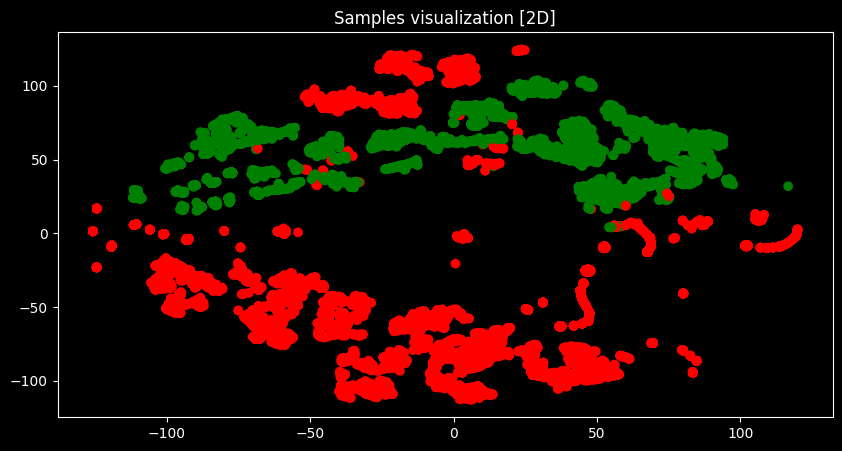

In [3]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_samples(samples, labels, title="Samples visualization", colors=["green", "red"]):
    """ Visualize first three dimensions of samples. """
    # Convert colors to NumPy array
    colors = np.array(colors)
    # Create figure
    fig = plt.figure(figsize=(10, 5))

    # 2D plot
    ax_2d = fig.add_subplot(1, 1, 1)
    ax_2d.set_title(f"{title} [2D]")
    ax_2d.scatter(samples[:, 0], samples[:, 1], c=colors[labels])

    print(fig)

# Visualize `StandardScaler` features (without dimensionality reduction)
visualize_samples(kdd_feat_std_tsne, y_std)

We will also use the following `timeit` function to monitor the training time of machine learning algorithms:

In [4]:
import time
from contextlib import contextmanager

@contextmanager
def timeit(action="Timing"):
    # Record start time
    print(f"{action} started...")
    start_time = time.time()

    # Execute task
    yield

    # Compute and show elapsed time
    elapsed_time = time.time()-start_time
    print(f"{action} completed. Elapsed time: {elapsed_time:.2f}s")

# Test timing function by sleeping for 1 second
with timeit("Testing timing function"):
    time.sleep(1)

Testing timing function started...
Testing timing function completed. Elapsed time: 1.00s


## Autoencoder

We will wrap up the introduction of dimensionality reduction algorithms with autoencoders. An **autoencoder** is a neural network used to learn a compact representation (also called encoding) for a set of data, typically for the purpose of dimensionality reduction. A typical regular autoencoder has a symmetric, five-layer structure shown below:

![autoencoder-structure.png](attachment:autoencoder-structure.png)

Like all other neural networks, the first layer is the **input layer** and the **last layer** is the output layer. For an autoencoder, the input layer and the output layer always have the same shape. We call the first three layers of the autoencoder **encoder network** and the last three layers **decoder network**. Hence, the second layer can be seen as the hidden layer of the encoder network and the fourth layer can be seen as the hidden layer of the decoder network. In practice, the shape of these layers are also made same. The third layer is the **encoder output layer**, and we make it the "bottleneck" of the autoencoder (by reducing its dimensions) so that the neural network learns to "compress" the information of previous encoder layers.

The goal of the autoencoder is to learn to **compress and reconstruct input features**, such that the **reconstruction resembles the original input** as much as possible. This forces the autoencoder to focus on the useful properties of the features and discard the noises. After training, we throw away the decoder network and use the encoder network to transform features. The result of the transformation will have fewer dimensions, yet it still preserves the characteristics and properties of the original, high-dimensional inputs.

From a formal perspective, we define the encoder transformation as $\phi: \mathcal{X} \rightarrow \mathcal{F}$ and the decoder transformation as $\psi: \mathcal{F} \rightarrow \mathcal{X}$, where $\mathcal{X}$ is the original feature space and $\mathcal{F}$ is the target feature space. Then the goal of the autoencoder is to minimize the mean-squared loss between the inputs and reconstructions:

$$
l_{AE} = ||X - \psi(\phi(X))||_2^2
$$

After training, we compute $F = \phi(X)$ to obtain target features with reduced dimensions.

Now, let's build an autoencoder in the following `make_ae_models` function. We have given you the dimensions of input features, hidden layers and the encoder output ("bottleneck") layer, as well as the activation layer type. Your task is to create an encoder and a decoder model, **both with three layers (this is different from the figure above!)**, according to the instructions in comments below. The `autoencoder_loss` function handles computation of the autoencoder (mean-squared) loss.

In [5]:
import torch
from torch import nn
from torch.nn import functional as f
from torch.utils.data import DataLoader

def get_torch_device():
    # Use CUDA (Nvidia/AMD GPU) if available
    if torch.cuda.is_available():
        device = "cuda"
    # Use MPS (Apple Silicon GPU) if available
    elif torch.backends.mps.is_available():
        device = "mps"
    # Fallback to CPU
    else:
        device = "cpu"

    return torch.device(device)


def make_ae_models(
    feat_dims, hidden_dims, bottleneck_dims,
    activation=nn.GELU, dropout_ratio=0., device="cpu"
):
    """Create and return both encoder and decoder PyTorch models."""

    # Define encoder model
    encoder_model = nn.Sequential(
        # Implement the encoder model to match the reference solution structure:
        #
        #   (*, feat_dims)
        #     -> Linear(feat_dims, hidden_dims)
        #     -> activation()
        #     -> Dropout(dropout_ratio)
        #     -> Linear(hidden_dims, bottleneck_dims)
        #
        # Add the 4 modules below in the correct order:
        nn.Linear(feat_dims, hidden_dims),
        activation(),
        nn.Dropout(dropout_ratio),
        nn.Linear(hidden_dims, bottleneck_dims),
    )

    # Define decoder model
    decoder_model = nn.Sequential(
        # Implement the decoder model to match the reference solution structure:
        #
        #   (*, bottleneck_dims)
        #     -> Linear(bottleneck_dims, hidden_dims)
        #     -> Dropout(dropout_ratio)
        #     -> activation()
        #     -> Linear(hidden_dims, feat_dims)
        #
        # Add the 4 modules below in the correct order:
        nn.Linear(bottleneck_dims, hidden_dims),
        nn.Dropout(dropout_ratio),
        activation(),
        nn.Linear(hidden_dims, feat_dims),
    )

    # Move models to given PyTorch device
    encoder_model = encoder_model.to(device)
    decoder_model = decoder_model.to(device)

    return encoder_model, decoder_model


def autoencoder_loss(feats, reconstructs, bottlenecks=None, l2_reg_factor=None):
    # Compute mean square error (main) loss between original and reconstructed features
    mse_loss = f.mse_loss(feats, reconstructs)

    # L2 regularization loss for bottleneck features
    if l2_reg_factor:
        l2_reg_loss = bottlenecks.square().sum(-1).mean()
        total_loss = mse_loss+l2_reg_factor*l2_reg_loss
    else:
        total_loss = mse_loss

    return total_loss, mse_loss

We then move on to the implementation of the training loop. This is a simpler version of what we did in lab 3 and homework 2 because no validation is required and thus only a single inner loop needs to be implemented.

In [6]:
from tqdm import tqdm

def train_autoencoder(encoder_model, decoder_model, optimizer, feats, n_epochs, batch_size, l2_reg_factor=0.,
    device=None):
    # Auto-detect PyTorch device from model parameters
    device = device or next(iter(encoder_model.parameters())).device
    # Make data loader for features
    loader = DataLoader(feats, batch_size, shuffle=True)

    for i in range(n_epochs):
        total_loss_epoch = 0.
        mse_loss_epoch = 0.

        print(f"Starting training epoch {i+1}/{n_epochs} ...")

        for feats_batch in tqdm(loader):
            feats_batch = feats.to(device)

            # Forward features through both encoder and decoder,
            # saving bottleneck and reconstructed features in the process
            bottlenecks = encoder_model(feats_batch)
            reconstructs = decoder_model(bottlenecks)
            # Compute autoencoder loss
            total_loss_batch, mse_loss_batch = autoencoder_loss(
                feats_batch, reconstructs, bottlenecks, l2_reg_factor
            )

            # Run an optimizer step
            total_loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Collect statistics
            total_loss_epoch += total_loss_batch.detach().cpu()
            mse_loss_epoch += mse_loss_batch.detach().cpu()

        total_loss_epoch /= len(loader)
        mse_loss_epoch /= len(loader)

        print(f"Training of epoch {i+1}/{n_epochs}: Total loss: {total_loss_epoch.item()}, MSE loss: {mse_loss_epoch.item()}")

Alright, we now have all the components we need to train an autoencoder, and then use it to reduce the dimensionality of our `StandardScaler` features (`kdd_feat_std_tensor`). We will perform these steps, and once we get the bottleneck features from our encoder model, we can visualize them through 2D and 3D plots:

Starting training epoch 1/50 ...


100%|██████████| 96/96 [00:00<00:00, 163.50it/s]


Training of epoch 1/50: Total loss: 0.14332497119903564, MSE loss: 0.14332497119903564
Starting training epoch 2/50 ...


100%|██████████| 96/96 [00:00<00:00, 154.05it/s]


Training of epoch 2/50: Total loss: 0.025769086554646492, MSE loss: 0.025769086554646492
Starting training epoch 3/50 ...


100%|██████████| 96/96 [00:00<00:00, 167.21it/s]


Training of epoch 3/50: Total loss: 0.014842662028968334, MSE loss: 0.014842662028968334
Starting training epoch 4/50 ...


100%|██████████| 96/96 [00:00<00:00, 162.95it/s]


Training of epoch 4/50: Total loss: 0.00931637641042471, MSE loss: 0.00931637641042471
Starting training epoch 5/50 ...


100%|██████████| 96/96 [00:00<00:00, 158.95it/s]


Training of epoch 5/50: Total loss: 0.005880198907107115, MSE loss: 0.005880198907107115
Starting training epoch 6/50 ...


100%|██████████| 96/96 [00:00<00:00, 162.12it/s]


Training of epoch 6/50: Total loss: 0.004939003847539425, MSE loss: 0.004939003847539425
Starting training epoch 7/50 ...


100%|██████████| 96/96 [00:00<00:00, 159.16it/s]


Training of epoch 7/50: Total loss: 0.0043692816980183125, MSE loss: 0.0043692816980183125
Starting training epoch 8/50 ...


100%|██████████| 96/96 [00:00<00:00, 156.06it/s]


Training of epoch 8/50: Total loss: 0.003909926395863295, MSE loss: 0.003909926395863295
Starting training epoch 9/50 ...


100%|██████████| 96/96 [00:00<00:00, 153.32it/s]


Training of epoch 9/50: Total loss: 0.0034679442178457975, MSE loss: 0.0034679442178457975
Starting training epoch 10/50 ...


100%|██████████| 96/96 [00:00<00:00, 158.12it/s]


Training of epoch 10/50: Total loss: 0.00309697980992496, MSE loss: 0.00309697980992496
Starting training epoch 11/50 ...


100%|██████████| 96/96 [00:00<00:00, 157.60it/s]


Training of epoch 11/50: Total loss: 0.0028246387373656034, MSE loss: 0.0028246387373656034
Starting training epoch 12/50 ...


100%|██████████| 96/96 [00:00<00:00, 144.54it/s]


Training of epoch 12/50: Total loss: 0.0026558113750070333, MSE loss: 0.0026558113750070333
Starting training epoch 13/50 ...


100%|██████████| 96/96 [00:00<00:00, 154.22it/s]


Training of epoch 13/50: Total loss: 0.002532157814130187, MSE loss: 0.002532157814130187
Starting training epoch 14/50 ...


100%|██████████| 96/96 [00:00<00:00, 158.94it/s]


Training of epoch 14/50: Total loss: 0.0024011165369302034, MSE loss: 0.0024011165369302034
Starting training epoch 15/50 ...


100%|██████████| 96/96 [00:00<00:00, 155.05it/s]


Training of epoch 15/50: Total loss: 0.002307865535840392, MSE loss: 0.002307865535840392
Starting training epoch 16/50 ...


100%|██████████| 96/96 [00:00<00:00, 160.23it/s]


Training of epoch 16/50: Total loss: 0.0022016281727701426, MSE loss: 0.0022016281727701426
Starting training epoch 17/50 ...


100%|██████████| 96/96 [00:00<00:00, 158.12it/s]


Training of epoch 17/50: Total loss: 0.0020781673956662416, MSE loss: 0.0020781673956662416
Starting training epoch 18/50 ...


100%|██████████| 96/96 [00:00<00:00, 157.34it/s]


Training of epoch 18/50: Total loss: 0.0020443147514015436, MSE loss: 0.0020443147514015436
Starting training epoch 19/50 ...


100%|██████████| 96/96 [00:00<00:00, 159.43it/s]


Training of epoch 19/50: Total loss: 0.0018799765966832638, MSE loss: 0.0018799765966832638
Starting training epoch 20/50 ...


100%|██████████| 96/96 [00:00<00:00, 164.63it/s]


Training of epoch 20/50: Total loss: 0.0018662391230463982, MSE loss: 0.0018662391230463982
Starting training epoch 21/50 ...


100%|██████████| 96/96 [00:00<00:00, 159.43it/s]


Training of epoch 21/50: Total loss: 0.001778089557774365, MSE loss: 0.001778089557774365
Starting training epoch 22/50 ...


100%|██████████| 96/96 [00:00<00:00, 158.12it/s]


Training of epoch 22/50: Total loss: 0.0017374660819768906, MSE loss: 0.0017374660819768906
Starting training epoch 23/50 ...


100%|██████████| 96/96 [00:00<00:00, 159.69it/s]


Training of epoch 23/50: Total loss: 0.0017083849525079131, MSE loss: 0.0017083849525079131
Starting training epoch 24/50 ...


100%|██████████| 96/96 [00:00<00:00, 157.86it/s]


Training of epoch 24/50: Total loss: 0.0016702759312465787, MSE loss: 0.0016702759312465787
Starting training epoch 25/50 ...


100%|██████████| 96/96 [00:00<00:00, 161.85it/s]


Training of epoch 25/50: Total loss: 0.0016837632283568382, MSE loss: 0.0016837632283568382
Starting training epoch 26/50 ...


100%|██████████| 96/96 [00:00<00:00, 156.31it/s]


Training of epoch 26/50: Total loss: 0.0016469639958813787, MSE loss: 0.0016469639958813787
Starting training epoch 27/50 ...


100%|██████████| 96/96 [00:00<00:00, 150.43it/s]


Training of epoch 27/50: Total loss: 0.0016097674379125237, MSE loss: 0.0016097674379125237
Starting training epoch 28/50 ...


100%|██████████| 96/96 [00:00<00:00, 159.16it/s]


Training of epoch 28/50: Total loss: 0.0016050091944634914, MSE loss: 0.0016050091944634914
Starting training epoch 29/50 ...


100%|██████████| 96/96 [00:00<00:00, 158.38it/s]


Training of epoch 29/50: Total loss: 0.0015904695028439164, MSE loss: 0.0015904695028439164
Starting training epoch 30/50 ...


100%|██████████| 96/96 [00:00<00:00, 158.90it/s]


Training of epoch 30/50: Total loss: 0.0015712208114564419, MSE loss: 0.0015712208114564419
Starting training epoch 31/50 ...


100%|██████████| 96/96 [00:00<00:00, 161.03it/s]


Training of epoch 31/50: Total loss: 0.0015772214392200112, MSE loss: 0.0015772214392200112
Starting training epoch 32/50 ...


100%|██████████| 96/96 [00:00<00:00, 152.83it/s]


Training of epoch 32/50: Total loss: 0.0015619279583916068, MSE loss: 0.0015619279583916068
Starting training epoch 33/50 ...


100%|██████████| 96/96 [00:00<00:00, 149.73it/s]


Training of epoch 33/50: Total loss: 0.0015316205099225044, MSE loss: 0.0015316205099225044
Starting training epoch 34/50 ...


100%|██████████| 96/96 [00:00<00:00, 154.06it/s]


Training of epoch 34/50: Total loss: 0.0015297653153538704, MSE loss: 0.0015297653153538704
Starting training epoch 35/50 ...


100%|██████████| 96/96 [00:00<00:00, 154.30it/s]


Training of epoch 35/50: Total loss: 0.0015277923084795475, MSE loss: 0.0015277923084795475
Starting training epoch 36/50 ...


100%|██████████| 96/96 [00:00<00:00, 153.07it/s]


Training of epoch 36/50: Total loss: 0.0015111226821318269, MSE loss: 0.0015111226821318269
Starting training epoch 37/50 ...


100%|██████████| 96/96 [00:00<00:00, 155.55it/s]


Training of epoch 37/50: Total loss: 0.0014718036400154233, MSE loss: 0.0014718036400154233
Starting training epoch 38/50 ...


100%|██████████| 96/96 [00:00<00:00, 154.06it/s]


Training of epoch 38/50: Total loss: 0.0014979876577854156, MSE loss: 0.0014979876577854156
Starting training epoch 39/50 ...


100%|██████████| 96/96 [00:00<00:00, 155.30it/s]


Training of epoch 39/50: Total loss: 0.0014742891071364284, MSE loss: 0.0014742891071364284
Starting training epoch 40/50 ...


100%|██████████| 96/96 [00:00<00:00, 151.49it/s]


Training of epoch 40/50: Total loss: 0.001477757003158331, MSE loss: 0.001477757003158331
Starting training epoch 41/50 ...


100%|██████████| 96/96 [00:00<00:00, 153.56it/s]


Training of epoch 41/50: Total loss: 0.0014440189115703106, MSE loss: 0.0014440189115703106
Starting training epoch 42/50 ...


100%|██████████| 96/96 [00:00<00:00, 156.57it/s]


Training of epoch 42/50: Total loss: 0.001466035726480186, MSE loss: 0.001466035726480186
Starting training epoch 43/50 ...


100%|██████████| 96/96 [00:00<00:00, 160.25it/s]


Training of epoch 43/50: Total loss: 0.0014259739546105266, MSE loss: 0.0014259739546105266
Starting training epoch 44/50 ...


100%|██████████| 96/96 [00:00<00:00, 165.76it/s]


Training of epoch 44/50: Total loss: 0.0014334196457639337, MSE loss: 0.0014334196457639337
Starting training epoch 45/50 ...


100%|██████████| 96/96 [00:00<00:00, 168.43it/s]


Training of epoch 45/50: Total loss: 0.001388097763992846, MSE loss: 0.001388097763992846
Starting training epoch 46/50 ...


100%|██████████| 96/96 [00:00<00:00, 160.69it/s]


Training of epoch 46/50: Total loss: 0.0013954057358205318, MSE loss: 0.0013954057358205318
Starting training epoch 47/50 ...


100%|██████████| 96/96 [00:00<00:00, 153.46it/s]


Training of epoch 47/50: Total loss: 0.0013795447302982211, MSE loss: 0.0013795447302982211
Starting training epoch 48/50 ...


100%|██████████| 96/96 [00:00<00:00, 161.04it/s]


Training of epoch 48/50: Total loss: 0.00137065548915416, MSE loss: 0.00137065548915416
Starting training epoch 49/50 ...


100%|██████████| 96/96 [00:00<00:00, 156.44it/s]


Training of epoch 49/50: Total loss: 0.0013332132948562503, MSE loss: 0.0013332132948562503
Starting training epoch 50/50 ...


100%|██████████| 96/96 [00:00<00:00, 150.10it/s]


Training of epoch 50/50: Total loss: 0.0013271417701616883, MSE loss: 0.0013271417701616883
Figure(1000x500)


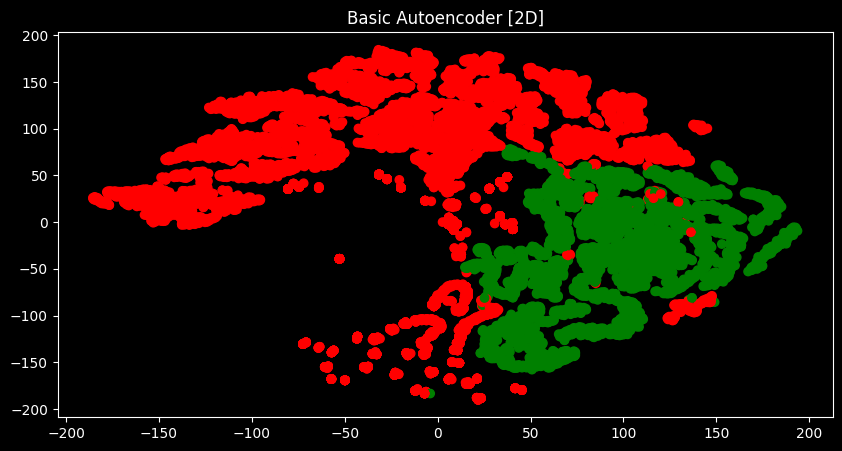

In [7]:
from itertools import chain

from torch.optim import AdamW

# Get preferred PyTorch device
torch_device = get_torch_device()
# Convert `kdd_feat_std` to PyTorch tensor, and put tensor on selected device
kdd_feat_std_tensor = torch.tensor(kdd_feat_std, device=torch_device, dtype=torch.float32)

# Make basic autoencoder models
enc_model_1, dec_model_1 = make_ae_models(
    feat_dims=kdd_feat_std.shape[1],
    hidden_dims=20,
    bottleneck_dims=10,
    device=torch_device
)
# Create optimizer for autoencoder models
optimizer = AdamW(
    chain(enc_model_1.parameters(), dec_model_1.parameters()),
    lr=0.005
)

# Train basic autoencoder models
train_autoencoder(
    enc_model_1, dec_model_1, optimizer, kdd_feat_std_tensor, n_epochs=50, batch_size=256
)
# Perform dimensionality reduction with the encoder
with torch.inference_mode():
    kdd_feat_ae_1 = enc_model_1(kdd_feat_std_tensor)
    kdd_feat_ae_1 = kdd_feat_ae_1.cpu().numpy()

# Run 2D t-SNE on StandardScaler features
autoenc_tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42,
)

kdd_feat_ae_1_tsne = autoenc_tsne.fit_transform(kdd_feat_ae_1)

# Plot basic autoencoder bottleneck features
visualize_samples(kdd_feat_ae_1_tsne, y_std, title="Basic Autoencoder")

Now that we have successfully trained our first autoencoder and transformed `StandardScaler` features to 10D space, we can try a few measures to improve it. First, we are going to **increase the capacity of the hidden layers** of our autoencoder. However, simply enlarging linear layers could make the autoencoder training more likely to overfit. Thus, we will **apply dropout** for the encoder and the decoder each. Another possible mitigation for the overfitting issue is **regularization**, which we will add to the encoder output so that the autoencoder loss becomes:

$$
l_{AE-L2} = ||X - \psi(\phi(X))||_2^2 + \lambda ||\phi(X)||_2^2
$$

To apply these improvements, go back to the `make_ae_models` function, then add [`torch.nn.Dropout`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layers between existing linear and activation layers. The L2 regularization is already implemented in `autoencoder_loss`, and you can enable it by forwarding the `l2_reg_factor` parameter for your `train_autoencoder` function. Finally, play with the hidden layer sizes, dropout ratio and L2 output regularization strength to see how the output features generated by the enhanced autoencoder actually look like.

Starting training epoch 1/50 ...


100%|██████████| 96/96 [00:01<00:00, 53.85it/s]


Training of epoch 1/50: Total loss: 0.11834514141082764, MSE loss: 0.11395809054374695
Starting training epoch 2/50 ...


100%|██████████| 96/96 [00:01<00:00, 53.80it/s]


Training of epoch 2/50: Total loss: 0.04309695586562157, MSE loss: 0.040594812482595444
Starting training epoch 3/50 ...


100%|██████████| 96/96 [00:01<00:00, 52.91it/s]


Training of epoch 3/50: Total loss: 0.03390861675143242, MSE loss: 0.03214343264698982
Starting training epoch 4/50 ...


100%|██████████| 96/96 [00:01<00:00, 52.88it/s]


Training of epoch 4/50: Total loss: 0.031003808602690697, MSE loss: 0.02963767945766449
Starting training epoch 5/50 ...


100%|██████████| 96/96 [00:01<00:00, 53.09it/s]


Training of epoch 5/50: Total loss: 0.02926238439977169, MSE loss: 0.028114572167396545
Starting training epoch 6/50 ...


100%|██████████| 96/96 [00:01<00:00, 54.82it/s]


Training of epoch 6/50: Total loss: 0.028077229857444763, MSE loss: 0.027080131694674492
Starting training epoch 7/50 ...


100%|██████████| 96/96 [00:01<00:00, 53.74it/s]


Training of epoch 7/50: Total loss: 0.027328962460160255, MSE loss: 0.02644089050590992
Starting training epoch 8/50 ...


100%|██████████| 96/96 [00:01<00:00, 53.95it/s]


Training of epoch 8/50: Total loss: 0.02639811672270298, MSE loss: 0.025588929653167725
Starting training epoch 9/50 ...


100%|██████████| 96/96 [00:01<00:00, 53.11it/s]


Training of epoch 9/50: Total loss: 0.025872284546494484, MSE loss: 0.025123534724116325
Starting training epoch 10/50 ...


100%|██████████| 96/96 [00:01<00:00, 53.14it/s]


Training of epoch 10/50: Total loss: 0.02559584565460682, MSE loss: 0.024886570870876312
Starting training epoch 11/50 ...


100%|██████████| 96/96 [00:01<00:00, 53.53it/s]


Training of epoch 11/50: Total loss: 0.02525169961154461, MSE loss: 0.02457955665886402
Starting training epoch 12/50 ...


100%|██████████| 96/96 [00:01<00:00, 49.96it/s]


Training of epoch 12/50: Total loss: 0.02508949674665928, MSE loss: 0.024439707398414612
Starting training epoch 13/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.11it/s]


Training of epoch 13/50: Total loss: 0.02489880472421646, MSE loss: 0.024276889860630035
Starting training epoch 14/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.05it/s]


Training of epoch 14/50: Total loss: 0.024330204352736473, MSE loss: 0.023729315027594566
Starting training epoch 15/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.46it/s]


Training of epoch 15/50: Total loss: 0.024433426558971405, MSE loss: 0.02385505475103855
Starting training epoch 16/50 ...


100%|██████████| 96/96 [00:01<00:00, 50.82it/s]


Training of epoch 16/50: Total loss: 0.024035528302192688, MSE loss: 0.023471452295780182
Starting training epoch 17/50 ...


100%|██████████| 96/96 [00:01<00:00, 52.07it/s]


Training of epoch 17/50: Total loss: 0.02373559959232807, MSE loss: 0.023189248517155647
Starting training epoch 18/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.15it/s]


Training of epoch 18/50: Total loss: 0.023830696940422058, MSE loss: 0.02329988218843937
Starting training epoch 19/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.74it/s]


Training of epoch 19/50: Total loss: 0.023600732907652855, MSE loss: 0.023078350350260735
Starting training epoch 20/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.13it/s]


Training of epoch 20/50: Total loss: 0.023431038483977318, MSE loss: 0.022920036688447
Starting training epoch 21/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.75it/s]


Training of epoch 21/50: Total loss: 0.02353561855852604, MSE loss: 0.023031817749142647
Starting training epoch 22/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.62it/s]


Training of epoch 22/50: Total loss: 0.023278646171092987, MSE loss: 0.02278517745435238
Starting training epoch 23/50 ...


100%|██████████| 96/96 [00:01<00:00, 50.85it/s]


Training of epoch 23/50: Total loss: 0.02325870282948017, MSE loss: 0.02277473174035549
Starting training epoch 24/50 ...


100%|██████████| 96/96 [00:01<00:00, 52.32it/s]


Training of epoch 24/50: Total loss: 0.0230559129267931, MSE loss: 0.022578999400138855
Starting training epoch 25/50 ...


100%|██████████| 96/96 [00:01<00:00, 52.25it/s]


Training of epoch 25/50: Total loss: 0.0229645986109972, MSE loss: 0.022495701909065247
Starting training epoch 26/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.21it/s]


Training of epoch 26/50: Total loss: 0.022873155772686005, MSE loss: 0.02241169847548008
Starting training epoch 27/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.01it/s]


Training of epoch 27/50: Total loss: 0.022739067673683167, MSE loss: 0.02228412963449955
Starting training epoch 28/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.40it/s]


Training of epoch 28/50: Total loss: 0.022856248542666435, MSE loss: 0.022408103570342064
Starting training epoch 29/50 ...


100%|██████████| 96/96 [00:01<00:00, 50.98it/s]


Training of epoch 29/50: Total loss: 0.022633085027337074, MSE loss: 0.022190777584910393
Starting training epoch 30/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.73it/s]


Training of epoch 30/50: Total loss: 0.02266657166182995, MSE loss: 0.022227570414543152
Starting training epoch 31/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.41it/s]


Training of epoch 31/50: Total loss: 0.022642070427536964, MSE loss: 0.02221009135246277
Starting training epoch 32/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.04it/s]


Training of epoch 32/50: Total loss: 0.022526241838932037, MSE loss: 0.022098449990153313
Starting training epoch 33/50 ...


100%|██████████| 96/96 [00:01<00:00, 52.51it/s]


Training of epoch 33/50: Total loss: 0.02256658673286438, MSE loss: 0.022146455943584442
Starting training epoch 34/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.86it/s]


Training of epoch 34/50: Total loss: 0.02257571555674076, MSE loss: 0.02216263674199581
Starting training epoch 35/50 ...


100%|██████████| 96/96 [00:01<00:00, 52.22it/s]


Training of epoch 35/50: Total loss: 0.02257751114666462, MSE loss: 0.02216898836195469
Starting training epoch 36/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.63it/s]


Training of epoch 36/50: Total loss: 0.022566288709640503, MSE loss: 0.02216253988444805
Starting training epoch 37/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.62it/s]


Training of epoch 37/50: Total loss: 0.022615579888224602, MSE loss: 0.022214382886886597
Starting training epoch 38/50 ...


100%|██████████| 96/96 [00:01<00:00, 53.11it/s]


Training of epoch 38/50: Total loss: 0.022364310920238495, MSE loss: 0.021963724866509438
Starting training epoch 39/50 ...


100%|██████████| 96/96 [00:01<00:00, 53.29it/s]


Training of epoch 39/50: Total loss: 0.02251747064292431, MSE loss: 0.02212178148329258
Starting training epoch 40/50 ...


100%|██████████| 96/96 [00:01<00:00, 52.68it/s]


Training of epoch 40/50: Total loss: 0.022332141175866127, MSE loss: 0.02194085717201233
Starting training epoch 41/50 ...


100%|██████████| 96/96 [00:02<00:00, 47.29it/s]


Training of epoch 41/50: Total loss: 0.022432269528508186, MSE loss: 0.022045092657208443
Starting training epoch 42/50 ...


100%|██████████| 96/96 [00:01<00:00, 52.36it/s]


Training of epoch 42/50: Total loss: 0.022363511845469475, MSE loss: 0.021977948024868965
Starting training epoch 43/50 ...


100%|██████████| 96/96 [00:01<00:00, 52.02it/s]


Training of epoch 43/50: Total loss: 0.022257216274738312, MSE loss: 0.021875454112887383
Starting training epoch 44/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.46it/s]


Training of epoch 44/50: Total loss: 0.02223578654229641, MSE loss: 0.02185642719268799
Starting training epoch 45/50 ...


100%|██████████| 96/96 [00:01<00:00, 50.52it/s]


Training of epoch 45/50: Total loss: 0.022225091233849525, MSE loss: 0.021850086748600006
Starting training epoch 46/50 ...


100%|██████████| 96/96 [00:01<00:00, 50.92it/s]


Training of epoch 46/50: Total loss: 0.022108450531959534, MSE loss: 0.02173580788075924
Starting training epoch 47/50 ...


100%|██████████| 96/96 [00:01<00:00, 52.45it/s]


Training of epoch 47/50: Total loss: 0.022242886945605278, MSE loss: 0.021871497854590416
Starting training epoch 48/50 ...


100%|██████████| 96/96 [00:01<00:00, 51.24it/s]


Training of epoch 48/50: Total loss: 0.022208409383893013, MSE loss: 0.021841755136847496
Starting training epoch 49/50 ...


100%|██████████| 96/96 [00:01<00:00, 52.08it/s]


Training of epoch 49/50: Total loss: 0.02214083820581436, MSE loss: 0.0217758696526289
Starting training epoch 50/50 ...


100%|██████████| 96/96 [00:01<00:00, 50.36it/s]


Training of epoch 50/50: Total loss: 0.022008957341313362, MSE loss: 0.021647440269589424
Figure(1000x500)


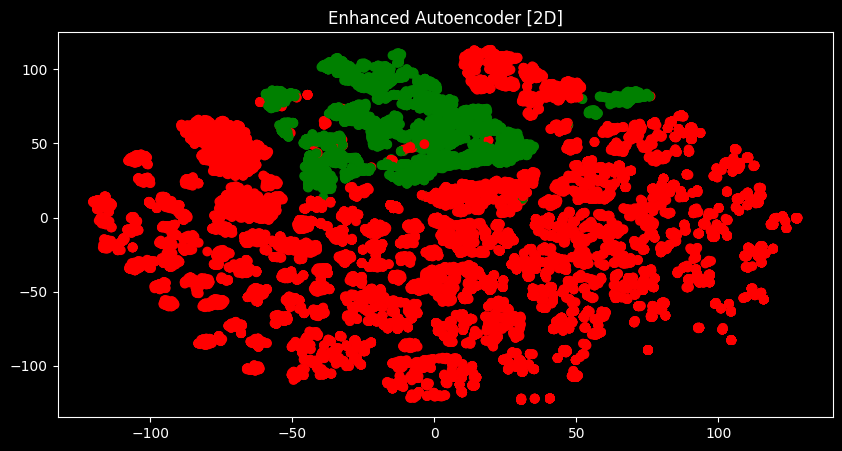

In [8]:
# Make enhanced autoencoder models with the following improvements:
# 1) Increased hidden layer capacity (`hidden_dims=25`)
# 2) Enable dropout to prevent over-fitting (`dropout_ratio=0.1`)
#
# NOTE: Use feat_dims=kdd_feat_std.shape[1] and device=torch_device
enc_model_2, dec_model_2 = make_ae_models(feat_dims=kdd_feat_std.shape[1],
                                            hidden_dims=25,
                                            bottleneck_dims=10,
                                            dropout_ratio=0.1,
                                            device=torch_device)

# Create optimizer for autoencoder models (fixed learning rate)
optimizer = AdamW(
    chain(enc_model_2.parameters(), dec_model_2.parameters()),
    lr=0.01
)

# Train enhanced autoencoder models
# Enable L2 regularization of decoder output (bottleneck features) using:
train_autoencoder(
    enc_model_2, dec_model_2, optimizer, kdd_feat_std_tensor,
    n_epochs=50, batch_size=256,
    l2_reg_factor=0.001
)

# Perform dimensionality reduction with the encoder
with torch.inference_mode():
    kdd_feat_ae_2 = enc_model_2(kdd_feat_std_tensor)
    kdd_feat_ae_2 = kdd_feat_ae_2.cpu().numpy()

# Run 2D t-SNE on the *autoencoder bottleneck features* (kdd_feat_ae_2) using:
# - n_components=2
# - perplexity=30
# - learning_rate="auto"
# - init="pca"
#
# Then:
# - fit_transform kdd_feat_ae_2
# - store result in kdd_feat_ae_2_tsne

kdd_feat_ae_2_tsne = TSNE(n_components=2,
                            perplexity=30,
                            learning_rate="auto",
                            init="pca").fit_transform(kdd_feat_ae_2)

# Plot enhanced autoencoder bottleneck features (2D tsne)
visualize_samples(kdd_feat_ae_2_tsne, y_std, title="Enhanced Autoencoder")

## Clustering

The second part of this lab involves clustering analysis, or simply **clustering**. It is the task of grouping samples into multiple groups (called **clusters**) such that samples within the same group are more similar than samples from different groups. Clustering algorithms are **unsupervised learning** algorithms because grouping is solely based on the features, without the need of any labels, though you will see in the later part of this lab that labels can help evaluate clustering result.

Like the previous lab, a few utility functions are required to compute metrics for clustering result. The first one is `confusion_matrix`, which does exactly the same thing as `sklearn.metrics.confusion_matrix`, except it allows different number of classes in predictions and true labels. This makes it handy for clustering result because the number of clusters may not necessarily equal to the number of true classes.

In [9]:
def confusion_matrix(actuals, preds):
    """ Extension of `sklearn.metrics.confusion_matrix`, suitable for clustering results. """
    # Number of classes of predictions and true labels
    n_classes_actual = max(actuals)+1
    n_classes_pred = max(preds)+1
    # Confusion matrix
    matrix = np.zeros((n_classes_pred, n_classes_actual), dtype=int)

    # Update matrix count for each sample
    for pred, actual in zip(preds, actuals):
        matrix[pred][actual] += 1

    return matrix

The second function computes the overall entropy of clustering result, when the true labels are available. Assume we have $c$ classes and $k$ clusters $\Omega = {\omega_1, \dots, \omega_k}$, the in-cluster entropy for cluster $i$ can be computed by:

$$
H(\omega_i) = -\sum_{j=1}^c \frac{|\omega_{ij}|}{|\omega_i|} \log \frac{|\omega_{ij}|}{|\omega_i|}
$$

where $\omega_{ij}$ represents samples that belong to both cluster $i$ and class $j$. The overall entropy of clustering result, which is the weighted average of in-cluster entropy, can then be computed as:

$$
H(\Omega) = \sum_{i=1}^k \frac{|\omega_i|}{|\Omega|} H(\omega_i)
$$

Later you will see that the overall entropy of clustering result is a good metric to determine the amount of clusters.

In [10]:
# Epsilon for entropy computation
EPSILON = 0.01

def clustering_entropy(conf_matrix):
    """ Compute the entropy of classification result. """
    zero_items = conf_matrix==0
    # Add an epsilon to zero elements in confusion matrix
    if zero_items.any():
        conf_matrix = conf_matrix.astype(float)
        conf_matrix[zero_items] += EPSILON

    # In-cluster sample distributions
    in_cluster_dists = conf_matrix/np.sum(conf_matrix, axis=-1, keepdims=True)
    # Entropy of all clusters
    entropy_clusters = -np.sum(in_cluster_dists*np.log(in_cluster_dists), axis=-1)

    # Proportion of samples of each cluster
    sample_props = np.sum(conf_matrix, axis=-1)/np.sum(conf_matrix)
    # Overall clustering entropy
    return np.sum(sample_props*entropy_clusters)

### K-means (Centroid-based clustering)

Strictly speaking, **K-means clustering** refers to the problem of partitioning sample features in to $k$ clusters, in which each sample belongs to the cluster with the nearest mean (also known as **centroid**). K-means minimizes in-cluster variances (mean squared distance of sample to corresponding cluster centroid) when forming such $k$ clusters. Mathmatically, the loss function of K-means can be written as follows:

$$
l_{K-Means} = \arg \min_S \sum_{i=1}^k \sum_{\mathbf{x} \in S_i} ||\mathbf{x} - \mathbf{\mu}_i||_2^2
$$

where $S$ represents the partition of all samples, $S_i$ represents cluster $i$, $\mu_i$ is the centroid (mean) of all samples within cluster $i$.

K-means itself is an NP-hard problem, meaning it's prohibitive to find the optimal partition. However in almost all cases, near optimal partition yielded by approximation algorithms would be good enough. The most commonly used algorithm to solve K-means problem is **Lloyd's algorithm**. It starts by randomly select $k$ cluster centers, then it alternates between two steps:

* Assignment: assign each sample to the cluster whose current center is the nearest.
* Update: for all samples within each cluster, recompute the center of clustering by setting it to the mean of all member samples.

The algorithm terminates when sample assignments no longer change. Later improvements, such as **K-means++ initialization**, further reduces the convergence time of the naive K-means algorithm.

In the following code cell, we run K-means clustering on raw `StandardScaler` features and t-SNE transformed `StandardScaler` features. Here let's set $k = 4$. We will compute the confusion matrix for both clustering results, then visualize the clustering result for t-SNE transformed `StandardScaler` features as it has only three dimensions:

K-Means (Raw features) started...
K-Means (Raw features) completed. Elapsed time: 0.05s
K-Means (AE-1) started...
K-Means (AE-1) completed. Elapsed time: 0.04s

Confusion matrix of K-means on raw features:
 [[ 4403 14183]
 [  272  1050]
 [   76  4355]] 

Confusion matrix of K-means on autoencoder transformed features (AE-1):
 [[  751    26]
 [    2  4347]
 [  453    24]
 [   25  1048]
 [ 2969   124]
 [    2 13995]
 [  284    15]
 [  265     9]] 

Confusion matrix of K-means on autoencoder transformed features (AE-2):
 [[   24  1397]
 [  211  1050]
 [    0  2042]
 [  432   103]
 [  294    21]
 [ 1921    38]
 [    0  2302]
 [ 1855    17]
 [   14 12618]] 

Figure(1000x500)
Figure(1000x500)


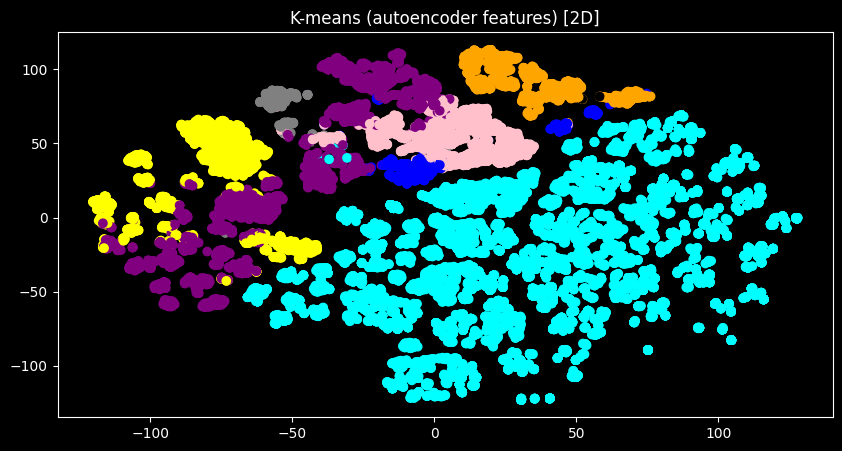

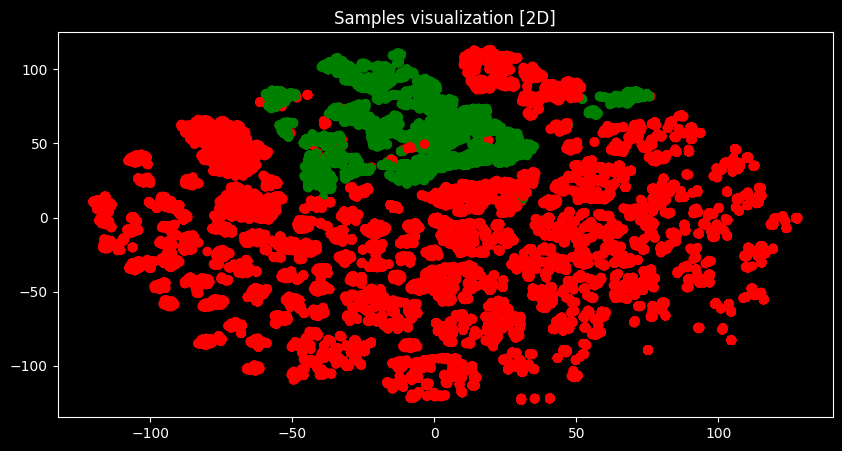

In [11]:
from sklearn.cluster import MiniBatchKMeans

# Perform K-means clustering using MiniBatchKMeans on:
#
# 1) Raw `StandardScaler` features: kdd_feat_std
#    - Use n_clusters=3, n_init="auto"
#    - Store the fitted model in k_means_std
#    - Store predictions in pred_k_means_std
#    - Wrap fit_predict with:  with timeit("K-Means (Raw features)"):
#
# 2) Autoencoder-1 bottleneck features: kdd_feat_ae_1
#    - Use n_clusters=8, n_init="auto"
#    - Store the fitted model in k_means_autoenc1
#    - Store predictions in pred_k_means_autoenc1
#    - Wrap fit_predict with:  with timeit("K-Means (AE-1)"):
#
# 3) Autoencoder-2 bottleneck features: kdd_feat_ae_2
#    - Use n_clusters=9, n_init="auto"
#    - Store the fitted model in k_means_autoenc2
#    - Store predictions in pred_k_means_autoenc2
#
# NOTE:
# - Use fit_predict(...) on the appropriate feature matrix for each case.
# - Do NOT run K-means on t-SNE features in this part.
k_means_std = MiniBatchKMeans(n_clusters=3, n_init="auto")
with timeit("K-Means (Raw features)"):
    pred_k_means_std = k_means_std.fit_predict(kdd_feat_std)

k_means_autoenc1 = MiniBatchKMeans(n_clusters=8, n_init="auto")
with timeit("K-Means (AE-1)"):
    pred_k_means_autoenc1 = k_means_autoenc1.fit_predict(kdd_feat_ae_1)

k_means_autoenc2 = MiniBatchKMeans(n_clusters=9, n_init="auto")
pred_k_means_autoenc2 = k_means_autoenc2.fit_predict(kdd_feat_ae_2)


print("")
# Confusion matrix of clustering results
print(
    "Confusion matrix of K-means on raw features:\n",
    confusion_matrix(y_std, pred_k_means_std), "\n"
)
print(
    "Confusion matrix of K-means on autoencoder transformed features (AE-1):\n",
    confusion_matrix(y_std, pred_k_means_autoenc1), "\n"
)
print(
    "Confusion matrix of K-means on autoencoder transformed features (AE-2):\n",
    confusion_matrix(y_std, pred_k_means_autoenc2), "\n"
)

# Plot K-means clustering result for AE-2 t-SNE embedding
visualize_samples(
    kdd_feat_ae_2_tsne, pred_k_means_autoenc2,
    title="K-means (autoencoder features)",
    colors=["black", "orange", "purple", "blue", "grey", "pink", "yellow", "purple", "cyan"]
)

# Plot ground-truth labels on the same AE-2 t-SNE embedding
visualize_samples(kdd_feat_ae_2_tsne, y_std)


You might wonder why we are clustering different models into different $k$ clusters. Why not $k = 2$ (which is the number of true classes)? Why not all models use the same $k$? To answer this question, we need to look at two metrics, the mean squared error (MSE) and the overall entropy. The **mean squared error** of K-means clustering refers to the average squared distance from each sample to its corresponding cluster center. It does not depends on any true labels and can be used in a purely unsupervised scenario. Smaller MSE indicates better clustering performance. The **overall entropy** of clustering result, on the other hand, depends on the true labels of samples, and is usually used in semi-supervised scenarios. It indicates how "pure" each cluster is, or in other words, how samples from a cluster concentrate into a single true class. Clearly, we want "purer" clustering result with least number of clusters.

In [12]:
import matplotlib.pyplot as plt

# Number of samples
n_samples = len(y_std)
# Maximal number of clusters to try
k_max = 15

# K-means MSEs for each `k` value
k_means_mse = []
# Overall clustering entropy for each `k` value
k_means_entropy = []

for k in range(1, k_max + 1):
    if k % 5 == 0:
        print(f"Running K-means for k = {k}...")

    # Learn `k` clusters during K-means clustering
    k_means_autoenc_try = MiniBatchKMeans(n_clusters=k, n_init="auto", random_state=87654321)

    # Cluster enhanced autoencoder transformed `StandardScaler` features (AE-2):
    # - Run fit_predict on kdd_feat_ae_2
    # - Store the predicted cluster IDs in pred_k_means_autoenc_try
    pred_k_means_autoenc_try = k_means_autoenc_try.fit_predict(kdd_feat_ae_2)

    # 1) Compute and store MSE for `k`
    #    - Use the trained model's inertia_ (sum of squared distances to centroids)
    #    - Convert it to per-sample MSE by dividing by n_samples
    #    - Append the result to k_means_mse
    #
    # 2) Compute and store clustering entropy for `k`
    #    - First compute confusion_matrix(y_std, pred_k_means_autoenc_try)
    #    - Then pass it to clustering_entropy(...)
    #    - Append the result to k_means_entropy
    k_means_mse.append(k_means_autoenc_try.inertia_ / n_samples)
    k_means_entropy.append(clustering_entropy(confusion_matrix(y_std, pred_k_means_autoenc_try)))


Running K-means for k = 5...
Running K-means for k = 10...
Running K-means for k = 15...


We have collected the mean squared error (MSE) and overall entropy for different number of K-means clusters. Now let's plot these metrics and see if we can find the best $k$ value:

Figure(2000x500)


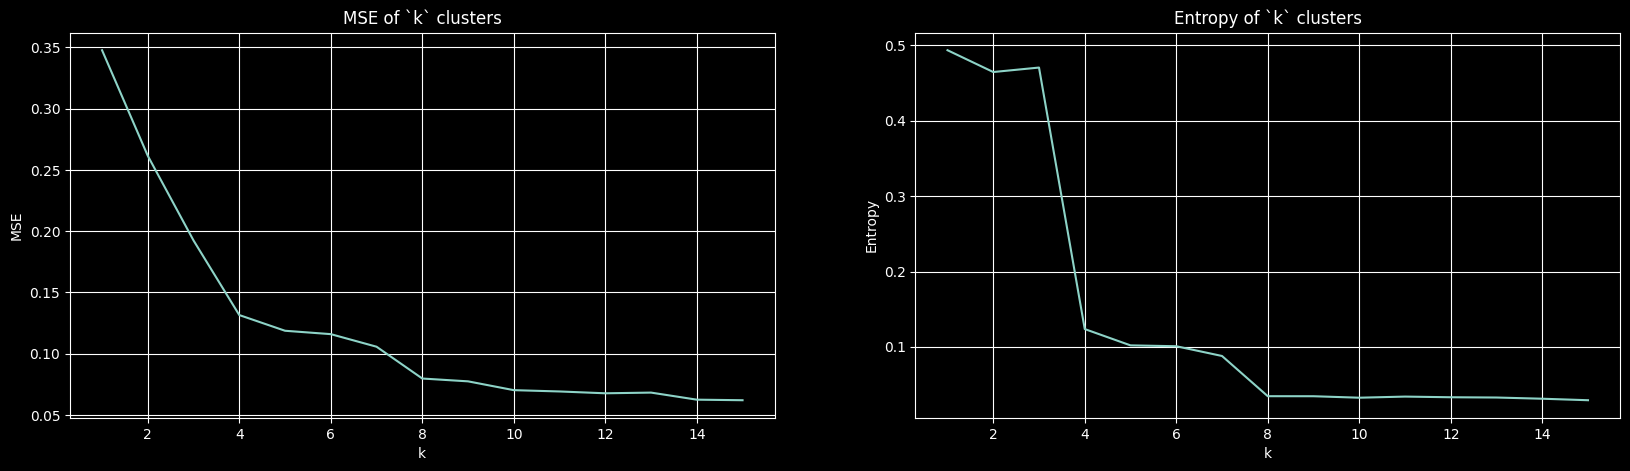

In [13]:
def plot_clustering_metrics(metrics_dict, fig_size=(20, 5)):
    """ Plot clustering metrics for different number of clusters. """
    # Number of metrics to plot
    n_metrics = len(metrics_dict)
    # Create plot for metrics
    fig = plt.figure(figsize=fig_size)

    for i, (metric_name, data) in enumerate(metrics_dict.items()):
        ax = fig.add_subplot(1, n_metrics, i+1)
        # Plot current metric on sub-plot
        ax.plot(np.arange(1, len(data)+1, dtype=int), data)

        # Title
        ax.set_title(f"{metric_name} of `k` clusters")
        # Axis labels
        ax.set_xlabel("k")
        ax.set_ylabel(metric_name)
        # Show grid
        ax.grid()

    # Show figure
    print(fig)

# Plot K-means MSE and clustering entropy
plot_clustering_metrics({
    "MSE": k_means_mse,
    "Entropy": k_means_entropy
})

The MSE plot does not show us anything useful, because MSE constantly decreases as the number of clusters increases. The overall entropy plot, on the other hand, gives us insights as we find $k = 4$ to be the local minimum of overall clustering entropy. This proves that partitioning samples into 4 clusters is a reasonable choice.

### Gaussian Mixture (Distribution-based Clustering)

Another popular clustering algorithm is Gaussian Mixture (GM) clustering, which utiltize **Gaussian mixture models**. A Gaussian mixture model is a mixture probability distribution consisting of several Gaussian distributions, each parameterized by mean $\mathbf{\mu}_i$ and variance $\mathbf{\Sigma}_i$. During training, we fit the Gaussian mixture model, such that its mixture proabability distribution matches the actual distribution of samples. This is done by iteratively performing **Expectation-Maximization (EM)**, which is somewhat similar to K-means:

* Expectation step (E step): compute the expected log likelihood of samples under the current mixture distribution.
* Maximization step (M step): maximize the expected log likelihood by adjusting distribution parameters.

When the EM algorithm converges, we compute the probability of all samples under each component Gaussian distribution. Then, the clustering category of a sample is determined by finding the Gaussian distribution under which the probability of the sample is the greatest.

In the following code cell, we run Gaussian Mixture clustering on raw `StandardScaler` features and t-SNE transformed `StandardScaler` features. We will set the number of clusters to 5. Again, we compute the confusion matrix for both clustering results, then visualize the clustering using for t-SNE transformed features:

Gaussian Mixture (Raw features) started...
Gaussian Mixture (Raw features) completed. Elapsed time: 0.34s

Gaussian Mixture (t-SNE) started...
Gaussian Mixture (t-SNE) completed. Elapsed time: 0.15s

Gaussian Mixture (t-SNE) started...
Gaussian Mixture (t-SNE) completed. Elapsed time: 0.17s

Confusion matrix of Gaussian Mixture on raw features:
 [[    2 13988]
 [    0  4353]
 [  271     0]
 [ 4476   199]
 [    2  1048]] 

Confusion matrix of Gaussian Mixture on autoencoder (AE-1) transformed features:
 [[    1 13976]
 [    0  4229]
 [ 1707   189]
 [  349   178]
 [    0  1016]
 [ 2694     0]] 

Confusion matrix of Gaussian Mixture on enhanced autoencoder (AE-2) transformed features:
 [[    1 13767]
 [    0  4274]
 [ 1191   140]
 [ 2433     1]
 [    0  1032]
 [ 1126   374]] 

Figure(1000x500)
Figure(1000x500)


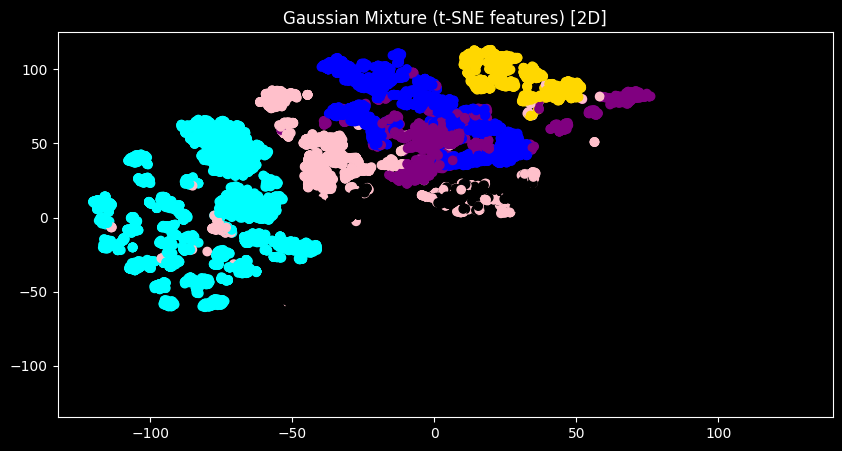

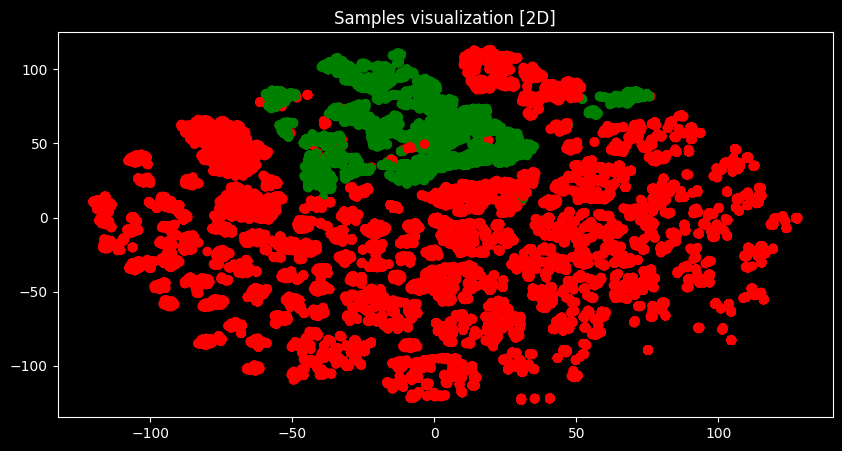

In [14]:
from sklearn.mixture import GaussianMixture

# Gaussian mixture clustering on raw `StandardScaler` features
# (Learn 4 clusters for all samples)
gm_std = GaussianMixture(n_components=5, random_state=87654321)
with timeit("Gaussian Mixture (Raw features)"):
    pred_gm_std = gm_std.fit_predict(kdd_feat_std)

print("")
# Gaussian mixture on autoencoder transformed `StandardScaler` features
gm_autoenc1 = GaussianMixture(n_components=6, random_state=87654321)
with timeit("Gaussian Mixture (t-SNE)"):
    pred_gm_autoenc1 = gm_autoenc1.fit_predict(kdd_feat_ae_1)

print("")

# Gaussian mixture on enhanced autoencoder transformed `StandardScaler` features
gm_autoenc2 = GaussianMixture(n_components=6, random_state=87654321)
with timeit("Gaussian Mixture (t-SNE)"):
    pred_gm_autoenc2 = gm_autoenc2.fit_predict(kdd_feat_ae_2)

print("")

# Confusion matrix of clustering results
print(
    "Confusion matrix of Gaussian Mixture on raw features:\n",
    confusion_matrix(y_std, pred_gm_std), "\n"
)
print(
    "Confusion matrix of Gaussian Mixture on autoencoder (AE-1) transformed features:\n",
    confusion_matrix(y_std, pred_gm_autoenc1), "\n"
)
print(
    "Confusion matrix of Gaussian Mixture on enhanced autoencoder (AE-2) transformed features:\n",
    confusion_matrix(y_std, pred_gm_autoenc2), "\n"
)

# Plot K-means clustering result for t-SNE transformed features
visualize_samples(
    kdd_feat_ae_2_tsne, pred_gm_autoenc2,
    title="Gaussian Mixture (t-SNE features)",
    colors=["black", "cyan", "purple", "blue", "gold","pink"]
)
visualize_samples(kdd_feat_ae_2_tsne, y_std)

Like K-means, we are interested in the best choice of number of clusters, so we compute and plot the overall clustering entropy for different number of clusters using the Gaussian Mixture clustering:

Running Gaussian Mixture for k = 5...
Running Gaussian Mixture for k = 10...
Running Gaussian Mixture for k = 15...
Figure(600x400)


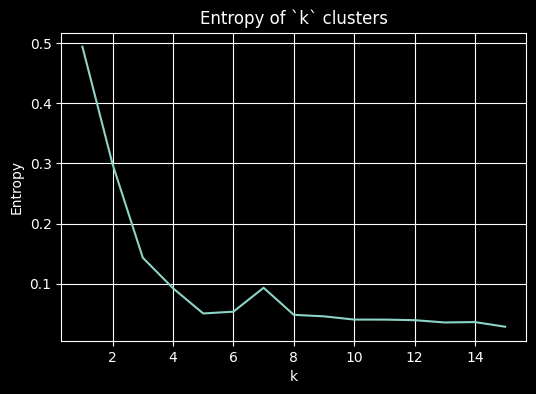

In [15]:
# Overall entropy for each `k` value
gm_entropy = []

# Maximal number of clusters to try
k_max = 15

for k in range(1, k_max+1):
    if k%5==0:
        print(f"Running Gaussian Mixture for k = {k}...")

    # Learn `k` clusters during gaussian mixture clustering
    gm_t_autoenc_try = GaussianMixture(n_components=k, random_state=87654321)
    # Cluster t-SNE transformed `StandardScaler` features
    pred_gm_autoenc_try = gm_t_autoenc_try.fit_predict(kdd_feat_ae_2)

    # Compute and store clustering entropy for `k`
    entropy_k = clustering_entropy(confusion_matrix(y_std, pred_gm_autoenc_try))
    gm_entropy.append(entropy_k)

# Plot overall clustering entropy for GM clustering results
plot_clustering_metrics({"Entropy": gm_entropy}, fig_size=(6, 4))

# 📝 Discussion Questions (Answer in this notebook)

> **Q1 (AE-2 + K-means): Choosing the number of clusters**  
> Using your **Entropy vs. k** plot for **K-means** on **AE-2 features**, justify the number of clusters **we chose** for AE-2.  
> In your justification, clearly refer to what you see in the plot.
>
A k of 9 was chosen for AE-2 as it is a point of low and stable entropy. As we can see in the plot, the entropy is high for k < 4 before drastically decreasing at k=4. Then, the entropy steadily decreases until reaching a stable and low value from k = 8 and beyond. We choose an early k value in this stable region to prevent overpartitioning using a higher k value.

> **Q2 (K-means): Best feature extraction method**  
> Using the **confusion matrices** you computed for **K-means**, decide which feature extraction method gives the best clustering results:  
> - raw standardized features (`kdd_feat_std`)  
> - AE-1 bottleneck features (`kdd_feat_ae_1`)  
> - AE-2 bottleneck features (`kdd_feat_ae_2`)  
> Explain your choice using specific patterns you observe in the confusion matrices.
>
>
AE-1 appears to give the best clustering results. We can see in the raw feature matrix, the first row [4403 14183] doesn't effectively separate the two results. So, this is not a good method. We can see in the AE-2 matrix, there are rows like [211  1050] that indicate there isn't the best separation either. Now, if we look at the AE-1 matrix, there are no rows with that low of separation. Almost every row has its smaller element in the tens place, which is significantly smaller than the typical larger element, which indicates the AE-1 method is separating the classes better than the raw and AE-2 methods.

> **Q3 (AE-2 + Gaussian Mixture): Choosing the number of clusters**  
> Using your **Entropy vs. k** plot for **Gaussian Mixture** on **AE-2 features**, justify the number of clusters **we chose** for AE-2.  
> Refer to what you see in the plot.
>
 A k of 6 was chosen for AE-2 as it is a point of low entropy without having too many clusters. As we can see in the plot, the entropy decreases for k<6, but increases to reach a local maximum at k = 7. As we increase k beyond 7, we see that entropy stabilizes at a low value that is similar to k=6. The differences in entropy between k=6 and k=14 are fairly minimal, so it is safe for us to represent the data with 6 clusters.

> **Q4 (Gaussian Mixture): Best feature extraction method**  
> Using the **confusion matrices** you computed for **Gaussian Mixture**, decide which feature extraction method gives the best clustering results:  
> - raw standardized features (`kdd_feat_std`)  
> - AE-1 bottleneck features (`kdd_feat_ae_1`)  
> - AE-2 bottleneck features (`kdd_feat_ae_2`)  
> Explain your choice using specific evidence from the confusion matrices.
>
The raw feature method appears to be the best as it separates the classes the best out of all methods. If we look at the weakest cluster, [4476   199], we see that 199 makes up 4% of 4476. This is quite low, so we can see there is good separation in this cluster. Now, if we look at AE-1's weakest cluster, [1126   374], 374/1126 = 33%, which is quite significant and shows that the classes aren't being properly separated. Finally, if we look at AE-2's weakest cluster, [349   178], 178/349 = 51%, which is the worst out of all the methods and indicates there is improper separation in that cluster. Thus, the raw feature method extracts features the best.


## References

1. KDD Cup 1999 Dataset: https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
2. Autoencoder: https://en.wikipedia.org/wiki/Autoencoder
3. K-means clustering: https://en.wikipedia.org/wiki/K-means_clustering
4. Lloyd's algorithm: https://en.wikipedia.org/wiki/Lloyd%27s_algorithm
5. K-means++: https://en.wikipedia.org/wiki/K-means%2B%2B
6. Mixture model: https://en.wikipedia.org/wiki/Mixture_model
7. Expectation-Maximization (EM): https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm